In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys
import time

import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import words

## Part a: Extracting Language Features

In [2]:
# the interview data (sheet 1)
interview_data = pd.read_excel(
    "/Users/calebkumar/Desktop/Desktop_Calebs_Pro/coding/ml/Mitigating-socio-demographic-bias/data/DAIC_demographic_data.xlsx",
    sheet_name="Interview_Data",
    skiprows=lambda x: x == 1,
)
# drop the rows where data in column Partic# is NaN
interview_data = interview_data.dropna(subset=["Partic#"])
print(interview_data.tail())

# the phq score data (sheet 2)
phq_score = pd.read_excel(
    "/Users/calebkumar/Desktop/Desktop_Calebs_Pro/coding/ml/Mitigating-socio-demographic-bias/data/DAIC_demographic_data.xlsx", sheet_name="Metadata_mapping"
)

print(phq_score.head())

     Partic# Condition  gender  race
428    837.0        AI     2.0     3
429    838.0        AI     1.0     1
430    839.0        AI     1.0     1
431    840.0        AI     2.0     3
432    841.0        AI     1.0     4
   Participant_ID  PHQ_Score
0             300          2
1             301          3
2             302          4
3             303          0
4             304          6


The following step was a workaround to prevent the end of file error due to unclosed inverted commas. What the code is doing - opening and reading each file, reading each line and checking for lines that start with " but does not end with " (i.e., checking for unclosed quotes).

In [3]:
# preprocessing the csv files to remove the unclosed inverted commas
def clean_csv(file_path, output_path):
    with open(file_path, "r") as infile, open(output_path, "w") as outfile:
        for line in infile:
            if line.startswith('"') and not line.endswith('"\n'):
                line = line[1:]
            outfile.write(line)


def process_directory(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(".csv"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            clean_csv(input_path, output_path)


input_dir = "/Users/calebkumar/Desktop/Desktop_Calebs_Pro/coding/ml/Mitigating-socio-demographic-bias/data/E-DAIC_Transcripts"
output_dir = "/Users/calebkumar/Desktop/Desktop_Calebs_Pro/coding/ml/Mitigating-socio-demographic-bias/E-DAIC_Transcripts_cleaned"

process_directory(input_dir, output_dir)

In [4]:
cleaned_transcripts_path = "/Users/calebkumar/Desktop/Desktop_Calebs_Pro/coding/ml/Mitigating-socio-demographic-bias/data/E-DAIC_Transcripts_cleaned"

transcripts = {}

# loop through each file in the folder, load it, and store the content
for filename in os.listdir(cleaned_transcripts_path):
    if filename.endswith("_Transcript.csv"):
        participant_id = filename.split("_")[0]  # extract the participant id
        file_path = os.path.join(cleaned_transcripts_path, filename)

        df = pd.read_csv(file_path)
        transcripts[participant_id] = df

# transcripts
transcripts["386"]

,Text
0,might have pulled something that
1,I'm going to bring the great thanks so much
2,and please
3,are you okay with this yes
4,oh I'm fine I'm a little tired but I found ou...
...,...
76,yeah well after college people usually many p...
77,thank you goodbye
78,oh that was that was fast
79,but I didn't never said there wasn't any like...


In [5]:
# combine all the text data for each participant into a single string
combined_transcripts = {}

for participant_id, transcript in transcripts.items():
    combined_transcripts[participant_id] = " ".join(transcript["Text"].astype(str))

# removing extra spaces caused by newlines
for participant_id, transcript in combined_transcripts.items():
    combined_transcripts[participant_id] = " ".join(transcript.split())

# combined_transcripts

for participant_id, transcript in list(combined_transcripts.items())[:3]:
    print(participant_id, transcript)

423 okay and please yes feeling well where are you from originally Los Angeles the Greater Los Angeles area people diversity and various entertainment and activities fickle weather traffic and litter do you travel I have travel domestically not internationally seeing other places and how people live in the culture I want to hear about one of your trips the last trip that I went to a San Diego butt out from childhood or as an adult family vacations to Baja in Rosarito Beach can you tell me yeah the reason why that memory comes to mind because this weekend is Easter and we usually will go down to East Easter spring break to Rosarito Baja am I have a Bachelors in communication studies because of the open field just doesn't deal with them communication interactively but Performing Arts telecommunications business entrepreneurship so no I'm not at Maxey unemployed what's your dream job I think 200 my business that's my dream my dream job to have my own company I would like to open something

In [6]:
# combine the demographic data with the extracted text data

from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# create the feature extractor objects here; using the base settings for now

corpus = list(combined_transcripts.values())
tfidf_vectorizer = TfidfVectorizer(stop_words="english", token_pattern=r"\b[A-Za-z]+\b")
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

sentiment_analyzer = SentimentIntensityAnalyzer()

combined_data = []

# convert the participant id in demographic data to int for consistency
interview_data["Partic#"] = interview_data["Partic#"].astype(int)


for _, row in interview_data.iterrows():
    participant_id = str(row["Partic#"])  # convert id to match the transcript ids

    # find langauge features for this participant
    if participant_id in combined_transcripts:
        transcript = combined_transcripts[participant_id]

        # sentiment features
        sentiment_pos_scores = sentiment_analyzer.polarity_scores(transcript)["pos"]

        # sentiment features
        sentiment_neu_scores = sentiment_analyzer.polarity_scores(transcript)["neu"]

        # sentiment features
        sentiment_neg_scores = sentiment_analyzer.polarity_scores(transcript)["neg"]

        # combine all the features
        data = {
            "participant_id": participant_id,
            "condition": row["Condition"],
            "race": row["race"],
            "genderData": row["gender"],
            # "tfidf_features": tfidf_features,
            # "count_features": count_features,
            "pos_sentiment": sentiment_pos_scores,
            "neu_sentiment": sentiment_neu_scores,
            "neg_sentiment": sentiment_neg_scores,
        }

        combined_data.append(data)

# convert the combined data into a dataframe
combined_data_df = pd.DataFrame(combined_data)

# print(combined_data_df.head())

# create dataframes for tf-idf and count features
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# concatenate the original DataFrame with the TF-IDF and Count DataFrames
final_df = pd.concat([combined_data_df.reset_index(drop=True), tfidf_df], axis=1)

tfidf_df.head(10)

,aa,aau,abandoned,abandoning,abby,abc,abducted,abilities,ability,able,...,zip,ziplining,zipping,zodiac,zoloft,zombie,zone,zuma,zurich,zz
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.073508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.018131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.055628,0.0,0.0,0.0,0.0,0.0,0.0,0.021266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.023153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- By removing common stop words and number, we went from $8702$ features to $8299$ features. We need to investigate how this affects the accuracy.
- Each term in the `TF-IDF` vector is considered a feature. The values represent the `TF-IDF` score for that term. A higher score could mean that the term is important to the transcript but not common in the entire list of transcripts. This is helpful in identifying the transcript's topic/sentiment.
- Initially, I decided on using the compound score, but that resulting list of scores are heavily skewed. Figuring something might be wrong, I reverted back to using individual metrics (positive, negative and neutral)

I noticed that using `CountVectorizer` just adds $8299$ more columns to the dataframe, making the already sparse dataset more sparse. Therefore, I decided to not use it.

In [7]:
# looking at the top 10 words with the highest tf-idf scores

feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum the TF-IDF scores for each feature across all documents
tfidf_scores = np.sum(tfidf_matrix.toarray(), axis=0)

# Create a DataFrame with feature names and their corresponding scores
tfidf_scores_df = pd.DataFrame({"feature": feature_names, "score": tfidf_scores})

# Sort the DataFrame by scores in descending order
tfidf_scores_df = tfidf_scores_df.sort_values(by="score", ascending=False)

# Get the top 10 features
top_10_features = tfidf_scores_df.head(10)

# Display the top 10 features
print(top_10_features)

     feature      score
6326       s  35.261808
7293       t  32.736003
4428       m  29.000342
4287    like  24.292047
4058    just  23.032052
4129    know  22.186805
2193     don  17.789652
5934  really  16.630834
3160    good  12.510597
7451   think  10.710480


In [8]:
corpus = list(combined_transcripts.values())

# create a TfidfVectorizer without removing stop words
vectorizer_no_stop_words = TfidfVectorizer(token_pattern=r"\b[A-Za-z]+\b")
vectorizer_no_stop_words.fit(corpus)
vocab_no_stop_words = set(vectorizer_no_stop_words.get_feature_names_out())

# create a TfidfVectorizer with stop_words='english'
vectorizer_with_stop_words = TfidfVectorizer(
    stop_words="english", token_pattern=r"\b[A-Za-z]+\b"
)
vectorizer_with_stop_words.fit(corpus)
vocab_with_stop_words = set(vectorizer_with_stop_words.get_feature_names_out())

# find the difference between the two vocabularies
removed_stop_words = vocab_no_stop_words - vocab_with_stop_words

print("Removed stop words number:", len(removed_stop_words))

Removed stop words number: 272


In [9]:
""" # creating 5 folds with shuffled data

from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

folds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(final_df):
    train_fold = final_df.iloc[train_index]
    test_fold = final_df.iloc[test_index]
    folds.append((train_fold, test_fold))

# display the first fold
# train_fold, test_fold = folds[0]
# print("Train Fold:")
# print(train_fold.head())
# print("\nTest Fold:")
# print(test_fold.head())

for i, (train_fold, test_fold) in enumerate(folds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n") """

' # creating 5 folds with shuffled data\n\nfrom sklearn.model_selection import KFold\n\n# initialize the KFold object with 5 splits\nkf = KFold(n_splits=5, shuffle=True, random_state=42)\n\nfolds = []\n\n# split the DataFrame into 5 folds\nfor train_index, test_index in kf.split(final_df):\n    train_fold = final_df.iloc[train_index]\n    test_fold = final_df.iloc[test_index]\n    folds.append((train_fold, test_fold))\n\n# display the first fold\n# train_fold, test_fold = folds[0]\n# print("Train Fold:")\n# print(train_fold.head())\n# print("\nTest Fold:")\n# print(test_fold.head())\n\nfor i, (train_fold, test_fold) in enumerate(folds):\n    print(f"Fold {i+1}:")\n    print(f"Train Fold Size: {len(train_fold)}")\n    print(f"Test Fold Size: {len(test_fold)}\n") '

### Optional: Doing more preprocessing to remove non-English words

_I used the NLTK library to exclude non-English words from the corpus. This reduces the number of features significantly, as you'll see below. I'm still not sure about removing the stop words though; you can try and see if disabling it helps with the performance._

_You can use this dataset to do the rest of the tasks. I only included this because I figured it might help with overfitting and consequentially, improve the model accuracies._

_For the folds, I have used the `final_df` dataset, which is the one that has $8306$ features. If you want, you can use the dataframe with the non-English words removed._

In [10]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download("words")

eng_words = set(words.words())

# preprocessing function


def preprocess_text(text):
    text = re.sub(r"\d+", "", text)  # Remove numbers
    tokens = re.findall(r"\b\w+\b", text)  # Tokenize
    valid_words = [
        token for token in tokens if token.lower() in eng_words
    ]  # Filter non-English words
    return " ".join(valid_words)


# create the feature extractor objects here; using the base settings for now

# corpus = list(combined_transcripts.values())
processed_corpus = [preprocess_text(text) for text in corpus]
tfidf_vectorizer_ = TfidfVectorizer(stop_words="english")
tfidf_matrix_ = tfidf_vectorizer_.fit_transform(processed_corpus)

sentiment_analyzer_ = SentimentIntensityAnalyzer()

combined_data_ = []

# convert the participant id in demographic data to int for consistency
interview_data["Partic#"] = interview_data["Partic#"].astype(int)


for _, row in interview_data.iterrows():
    participant_id = str(row["Partic#"])  # convert id to match the transcript ids

    # find langauge features for this participant
    if participant_id in combined_transcripts:
        transcript = combined_transcripts[participant_id]

        # sentiment features
        sentiment_pos_scores = sentiment_analyzer.polarity_scores(transcript)["pos"]

        # sentiment features
        sentiment_neu_scores = sentiment_analyzer.polarity_scores(transcript)["neu"]

        # sentiment features
        sentiment_neg_scores = sentiment_analyzer.polarity_scores(transcript)["neg"]

        # combine all the features
        data = {
            "participant_id": participant_id,
            "condition": row["Condition"],
            "race": row["race"],
            "genderData": row["gender"],
            # "tfidf_features": tfidf_features,
            # "count_features": count_features,
            "pos_sentiment": sentiment_pos_scores,
            "neu_sentiment": sentiment_neu_scores,
            "neg_sentiment": sentiment_neg_scores,
        }

        combined_data_.append(data)

# convert the combined data into a dataframe
combined_data_df_ = pd.DataFrame(combined_data_)

# print(combined_data_df.head())

# create dataframes for tf-idf and count features
tfidf_df_ = pd.DataFrame(
    tfidf_matrix_.toarray(), columns=tfidf_vectorizer_.get_feature_names_out()
)

# concatenate the original DataFrame with the TF-IDF and Count DataFrames
final_df_ = pd.concat([combined_data_df_.reset_index(drop=True), tfidf_df_], axis=1)

final_df_.head()

[nltk_data] Downloading package words to
[nltk_data]     /Users/calebkumar/nltk_data...
[nltk_data]   Package words is already up-to-date!


,participant_id,condition,race,genderData,pos_sentiment,neu_sentiment,neg_sentiment,aa,abandoned,ability,...,youth,yule,zany,zero,zest,zip,zipping,zodiac,zombie,zone
0,386,WoZ,3,2.0,0.184,0.770,0.046,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,387,WoZ,1,1.0,0.285,0.665,0.050,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,388,WoZ,4,1.0,0.161,0.769,0.070,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,389,WoZ,1,1.0,0.116,0.827,0.057,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,390,WoZ,3,1.0,0.193,0.740,0.067,0.0,0.068101,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


By excluding non-english words, along with removing stop words, I was able to reduce the number of features significantly - from $8299$ to $5327$. This may produce better results.

In [11]:
feature_names_ = tfidf_vectorizer_.get_feature_names_out()

# Sum the TF-IDF scores for each feature across all documents
tfidf_scores_ = np.sum(tfidf_matrix_.toarray(), axis=0)

# Create a DataFrame with feature names and their corresponding scores
tfidf_scores_df_ = pd.DataFrame({"feature": feature_names_, "score": tfidf_scores_})

# Sort the DataFrame by scores in descending order
tfidf_scores_df_ = tfidf_scores_df_.sort_values(by="score", ascending=False)

# Get the top 10 features
top_10_features_ = tfidf_scores_df_.head(10)

# Display the top 10 features
print(top_10_features_)

     feature      score
2752    like  29.028222
2612    just  27.465559
2650    know  26.661350
1405     don  21.508594
3770  really  19.885133
2048    good  14.995024
4768   think  12.867584
3400  people  12.553898
4795    time  12.395769
2044   going  11.075604


## Part b: Classifying by Gender

In [ ]:
useNonEnglishWordRemovalDatasetFlag = False

if useNonEnglishWordRemovalDatasetFlag:
    genderDF = final_df_.drop(["race", "condition", "participant_id"], axis=1)
else:
    genderDF = final_df.drop(["race", "condition", "participant_id"], axis=1)

genderDF = genderDF.dropna()

# map gender from [1,2] -> [0,1] (XGBoost needs the labels to be 0 or 1)
genderDF["genderData"] = genderDF["genderData"].map({1: 0, 2: 1})

targetGender = genderDF.pop("genderData")

In [ ]:
from scipy.stats import pearsonr

genderCorr = []

for i, (cols) in enumerate(genderDF.columns):

    corr, p = pearsonr(genderDF[cols], targetGender)
    genderCorr.append(corr)

In [ ]:
from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

genderFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(genderDF):
    train_fold = genderDF.iloc[train_index]
    test_fold = genderDF.iloc[test_index]
    train_target_fold = targetGender.iloc[train_index]
    test_target_fold = targetGender.iloc[test_index]
    genderFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))

for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(genderFolds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n")

Fold 1:
Train Fold Size: 150
Test Fold Size: 38

Fold 2:
Train Fold Size: 150
Test Fold Size: 38

Fold 3:
Train Fold Size: 150
Test Fold Size: 38

Fold 4:
Train Fold Size: 151
Test Fold Size: 37

Fold 5:
Train Fold Size: 151
Test Fold Size: 37



In [43]:
# helper function to calcualte accuracy and balanced accuracy
def getAccAndBAcc(yPred, yTrue):

    truePos = 0
    trueNeg = 0
    falsePos = 0
    falseNeg = 0

    for idx in range(len(yPred)):
        
        if yPred[idx] == 1:

            if yTrue[idx] == 1:

                truePos += 1

            else:

                falseNeg += 1

        else:

            if yTrue[idx] == 1:

                falsePos += 1

            else:

                trueNeg += 1

    if (trueNeg+falsePos) == 0 and (truePos+falseNeg) != 0:
        balancedAccuracy = 0.5*truePos/(truePos+falseNeg)
    elif (trueNeg+falsePos) != 0 and (truePos+falseNeg) == 0:
        balancedAccuracy = 0.5*trueNeg/(trueNeg+falsePos)
    else:
        balancedAccuracy = 0.5*trueNeg/(trueNeg+falsePos) + 0.5*truePos/(truePos+falseNeg)
    
    accuracy = (truePos + trueNeg) / (truePos + trueNeg + falsePos + falseNeg)

    return accuracy, balancedAccuracy

In [ ]:
# create deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def getDLModel(inputShape):

    model = Sequential([
        Dense(128, activation='relu', input_shape=(inputShape,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics = ["accuracy"]
    )

    return model

In [ ]:
import xgboost as xgb

numberOfFeatures = [len(genderDF.columns)-1, 4000, 3000, 2000, 1000, 500]

bAccTree = []
accTree  = []

bAccDL = []
accDL  = []

top_n_idx = lambda data, n: np.argsort(data)[-n:]

for n in numberOfFeatures:

    nIdx = top_n_idx(genderCorr, n)

    nCols = genderDF.columns[nIdx]

    foldAccTree = []
    foldBAccTree = []

    foldAccDL = []
    foldBAccDL = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(genderFolds):

        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # train XGBoost model
        xgb_classifier = xgb.XGBClassifier()
        xgb_classifier.fit(train_fold, train_target_fold)

        # get test accuracy and balanced accuracy
        acc, bAcc = getAccAndBAcc(xgb_classifier.predict(test_fold), test_target_fold.to_numpy())

        # store accuracies
        foldAccTree.append(acc)
        foldBAccTree.append(bAcc)

        # train DL model
        FNN = getDLModel(train_fold.shape[1])
        FNN.fit(train_fold, train_target_fold, epochs=100, verbose=0)

        # get test accuracy and balanced accuracy
        acc, bAcc = getAccAndBAcc(FNN.predict(test_fold), test_target_fold.to_numpy())

        # store accuracies
        foldAccDL.append(acc)
        foldBAccDL.append(bAcc)

    accTree.append(np.mean(foldAccTree))
    bAccTree.append(np.mean(foldBAccTree))
    
    accDL.append(np.mean(foldAccDL))
    bAccDL.append(np.mean(foldBAccDL))

print("\n")
for idx in range(len(numberOfFeatures)):

    print("#######################################")
    print(f"Values for {numberOfFeatures[idx]} top features:")
    print(f"Tree accuracy: {accTree[idx]}")
    print(f"Tree balanced accuracy: {bAccTree[idx]}")
    print(f"DL accuracy: {accDL[idx]}")
    print(f"DL balanced accuracy: {bAccDL[idx]}")


maxTreeBAccNumFeatures = numberOfFeatures[np.argmax(bAccTree)]
maxDLBAccNumFeatures = numberOfFeatures[np.argmax(bAccDL)]

print("\n")
print("#######################################")
print(f"Max Tree Number of Features: {maxTreeBAccNumFeatures}, with balanced accuracy of {np.max(bAccTree) * 100}%")
print(f"Max DL Number of Features: {maxDLBAccNumFeatures}, with balanced accuracy of {np.max(bAccDL) * 100}%")
print("#######################################")


2/2 [==============================] - 0s 0s/step


#######################################
Values for 8299 top features:
Tree accuracy: 0.6541963015647226
Tree balanced accuracy: 0.6286279289037909
DL accuracy: 0.6113798008534851
DL balanced accuracy: 0.30568990042674254
#######################################
Values for 4000 top features:
Tree accuracy: 0.6600284495021338
Tree balanced accuracy: 0.6597334147334147
DL accuracy: 0.6113798008534851
DL balanced accuracy: 0.30568990042674254
#######################################
Values for 3000 top features:
Tree accuracy: 0.6331436699857753
Tree balanced accuracy: 0.6218678931582157
DL accuracy: 0.6113798008534851
DL balanced accuracy: 0.30568990042674254
#######################################
Values for 2000 top features:
Tree accuracy: 0.7237553342816501
Tree balanced accuracy: 0.7313808260704813
DL accuracy: 0.6113798008534851
DL balanced accuracy: 0.30568990042674254
#######################################
Values for 1000 top feat

# Part - C

To classify for race I used two models. LightBoost, a flavor of XGBoost and an FNN for classification. The Lightboost models is because after data exploration there was a class imbalance for the races in the dataset. The FNN was kept simple due to the small amounts of data available. To create the dataset, i took the top 500 informative features (summed for all patients) and iterated through feature amounts.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Attention, Flatten, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [11]:
def getAccAndBAcc_multi_class(yPred, yTrue):
    acc = accuracy_score(yPred, yTrue)
    bAcc = balanced_accuracy_score(yPred, yTrue)
    return acc, bAcc
    # classes = np.unique(np.concatenate([yPred, yTrue]))
    # recalls = []
    #
    # for cls in classes:
    #     # True Positives: Predicted and True are the same for this class
    #     truePos = np.sum((yPred == cls) & (yTrue == cls))
    #     # False Negatives: True is this class but Predicted is not
    #     falseNeg = np.sum((yPred != cls) & (yTrue == cls))
    #     # Compute recall for this class
    #     recall = truePos / (truePos + falseNeg) if (truePos + falseNeg) > 0 else 0
    #     recalls.append(recall)
    #
    # balancedAccuracy = np.mean(recalls)
    # accuracy = np.mean(yPred == yTrue)
    #
    # return accuracy, balancedAccuracy


In [12]:
global_feature_importance = tfidf_df.sum(axis=0)
top_features = global_feature_importance.sort_values(ascending=False)
top_feature_names = top_features.head(500).index
top_feature_names

Index(['s', 't', 'm', 'like', 'just', 'know', 'don', 'really', 'good', 'think',
       ...
       'traveled', 'cranky', 'leaving', 'service', 'ideal', 'watching',
       'virtual', 'drinking', 'loving', 'boys'],
      dtype='object', length=500)

In [13]:
reduced_tfidf_df = tfidf_df[top_feature_names]
dataset = pd.concat([combined_data_df.reset_index(drop=True), reduced_tfidf_df.reset_index(drop=True)], axis=1)
dataset

,participant_id,condition,race,genderData,pos_sentiment,neu_sentiment,neg_sentiment,s,t,m,...,traveled,cranky,leaving,service,ideal,watching,virtual,drinking,loving,boys
0,386,WoZ,3,2.0,0.184,0.770,0.046,0.095581,0.143372,0.167267,...,0.0,0.0,0.0,0.036242,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,387,WoZ,1,1.0,0.285,0.665,0.050,0.227780,0.072475,0.124243,...,0.0,0.0,0.0,0.000000,0.034808,0.000000,0.0,0.068496,0.000000,0.0
2,388,WoZ,4,1.0,0.161,0.769,0.070,0.255382,0.286027,0.112368,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,389,WoZ,1,1.0,0.116,0.827,0.057,0.145214,0.290428,0.127062,...,0.0,0.0,0.0,0.000000,0.000000,0.056575,0.0,0.000000,0.000000,0.0
4,390,WoZ,3,1.0,0.193,0.740,0.067,0.179721,0.179721,0.071889,...,0.0,0.0,0.0,0.000000,0.040280,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,713,AI,3,NaN,0.120,0.800,0.080,0.055867,0.195533,0.111733,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
186,715,AI,1,1.0,0.135,0.813,0.051,0.261367,0.200196,0.216879,...,0.0,0.0,0.0,0.000000,0.000000,0.017332,0.0,0.000000,0.035159,0.0
187,716,AI,4,1.0,0.161,0.730,0.109,0.078655,0.146074,0.191019,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
188,717,AI,1,1.0,0.152,0.791,0.058,0.134177,0.082571,0.061928,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [14]:
race_df = dataset.drop(["condition", "participant_id"], axis=1)
race_df = race_df.dropna()
y_race = race_df.pop("race")
y_race = y_race - 1

In [15]:
race_df.shape, y_race.shape

((188, 504), (188,))

In [16]:
def get_dense_model(input_shape):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(7, activation="softmax")  # 7 classes
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
race_folds = []

for train_index, test_index in skf.split(race_df, y_race):
    # print(train_index, test_index)
    train_fold = race_df.iloc[train_index]
    test_fold = race_df.iloc[test_index]
    train_target_fold = y_race.iloc[train_index]
    test_target_fold = y_race.iloc[test_index]
    race_folds.append((train_fold, train_target_fold, test_fold, test_target_fold))

In [18]:
correlation_df = race_df.corrwith(y_race)
correlation_df = correlation_df.reset_index()
correlation_df.columns = ['Feature', 'Correlation']

In [19]:
race_corr = correlation_df["Correlation"].dropna()
race_corr = race_corr.tolist()
# np.nan in race_corr

In [21]:
idx = np.argsort(race_corr)
idx = idx[::-1]

top10Cols = race_df.columns[idx[:20]].tolist()
top10Scores = np.sort(race_corr)
top10Scores = top10Scores[::-1]
top10Scores = top10Scores[:20]

print("Most Correlated Values")
for ii in range(10):
    print(f"{top10Cols[ii]}: {top10Scores[ii]}")

Most Correlated Values
married: 0.3441285075504157
alive: 0.2359002175529838
point: 0.2129610060848315
old: 0.20614722973201
situation: 0.20205210194142945
best: 0.18322723476863062
listen: 0.17520291670753077
friendly: 0.17261108554219057
talked: 0.16691314152642212
able: 0.16376094942346447


In [22]:
for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(race_folds):
    print(f"Fold {i + 1} - Train classes: {train_target_fold.unique()}, Test classes: {test_target_fold.unique()}")

Fold 1 - Train classes: [0 3 2 1 6 4 5], Test classes: [2 0 3 6 4 1]
Fold 2 - Train classes: [2 0 3 6 1 4 5], Test classes: [3 0 1 2 6 4]
Fold 3 - Train classes: [2 0 3 6 1 4], Test classes: [2 0 3 6 1 5]
Fold 4 - Train classes: [2 3 0 6 1 4 5], Test classes: [0 2 3 1 6]
Fold 5 - Train classes: [2 0 3 6 1 4 5], Test classes: [3 2 6 0 1 4]


In [23]:
numberOfFeatures = [len(race_df.columns)-1, 400, 300, 200, 100, 50]

In [24]:
accTree = []
bAccTree = []

for n in numberOfFeatures:

    nCols = race_df.columns[:n]

    # print("NCOLS \n",nCols)

    foldAccTree = []
    foldBAccTree = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(race_folds):

        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # print(f"train_fold shape: \n{train_fold.shape}")
        # print(f"train_target_fold shape: \n{train_target_fold.shape}")
        # print(f"test_fold shape: \n{test_fold.shape}")
        # print(f"test_target_fold shape: \n{test_target_fold.shape}")

        train_data = lgb.Dataset(train_fold, label=train_target_fold)
        test_data = lgb.Dataset(test_fold, label=test_target_fold)

        # try random stuff to see if it works
        params = {
            'objective': 'multiclass',
            'num_class': 7,
            'metric': 'multi_logloss',
            'is_unbalance': True,  # Address class imbalance
            'boosting_type': 'gbdt',
            'learning_rate': 0.001,
            'max_depth': 8,
            'num_leaves': 30,
            'verbose': -1
        }

        lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

        predictions = lgb_model.predict(test_fold)
        predicted_classes = predictions.argmax(axis=1)
        acc, bAcc = getAccAndBAcc_multi_class(predicted_classes, test_target_fold.to_numpy())

        foldAccTree.append(acc)
        foldBAccTree.append(bAcc)

    accTree.append(np.mean(foldAccTree))
    bAccTree.append(np.mean(foldBAccTree))


In [25]:
bAccDL = []
accDL = []

for n in numberOfFeatures:

    nCols = race_df.columns[:n]

    foldAccDL = []
    foldBAccDL = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(race_folds):

        # Use only top-n columns
        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # Train Dense Neural Network
        FNN = get_dense_model(train_fold.shape[1])
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
        ]
        # print("TF \n", train_fold, "\n")
        # print("TRAIN target \n", train_target_fold, "\n")
        # print("TEST target \n", test_target_fold)
        # callbacks=callbacks,
        FNN.fit(train_fold, train_target_fold, validation_split=0.2, callbacks=callbacks, epochs=100,  verbose=0)

        # Evaluate Dense Neural Network
        fnn_predictions = FNN.predict(test_fold).argmax(axis=1)
        # print(fnn_predictions)
        acc, bAcc = getAccAndBAcc_multi_class(fnn_predictions, test_target_fold.to_numpy())

        foldAccDL.append(acc)
        foldBAccDL.append(bAcc)

    accDL.append(np.mean(foldAccDL))
    bAccDL.append(np.mean(foldBAccDL))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x33c4683a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━

In [26]:
print("\n")
for idx in range(len(numberOfFeatures)):

    print("#######################################")
    print(f"Values for {numberOfFeatures[idx]} top features:")
    print(f"Tree accuracy: {accTree[idx]}")
    print(f"Tree balanced accuracy: {bAccTree[idx]}")
    print(f"DL accuracy: {accDL[idx]}")
    print(f"DL balanced accuracy: {bAccDL[idx]}")


maxTreeBAccNumFeatures = numberOfFeatures[np.argmax(bAccTree)]
maxDLBAccNumFeatures = numberOfFeatures[np.argmax(bAccDL)]

print("\n")
print("#######################################")
print(f"Max Tree Number of Features: {maxTreeBAccNumFeatures}, with balanced accuracy of {np.max(bAccTree) * 100}%")
print(f"Max DL Number of Features: {maxDLBAccNumFeatures}, with balanced accuracy of {np.max(bAccDL) * 100}%")
print("#######################################")



#######################################
Values for 503 top features:
Tree accuracy: 0.4042674253200569
Tree balanced accuracy: 0.36586059743954485
DL accuracy: 0.4147937411095306
DL balanced accuracy: 0.38002328954341336
#######################################
Values for 400 top features:
Tree accuracy: 0.4042674253200569
Tree balanced accuracy: 0.36586059743954485
DL accuracy: 0.393172119487909
DL balanced accuracy: 0.32532163742690057
#######################################
Values for 300 top features:
Tree accuracy: 0.4042674253200569
Tree balanced accuracy: 0.36586059743954485
DL accuracy: 0.40938833570412514
DL balanced accuracy: 0.3879642800695432
#######################################
Values for 200 top features:
Tree accuracy: 0.4042674253200569
Tree balanced accuracy: 0.36586059743954485
DL accuracy: 0.4200568990042674
DL balanced accuracy: 0.43248379958906275
#######################################
Values for 100 top features:
Tree accuracy: 0.4095305832147938
Tree balance

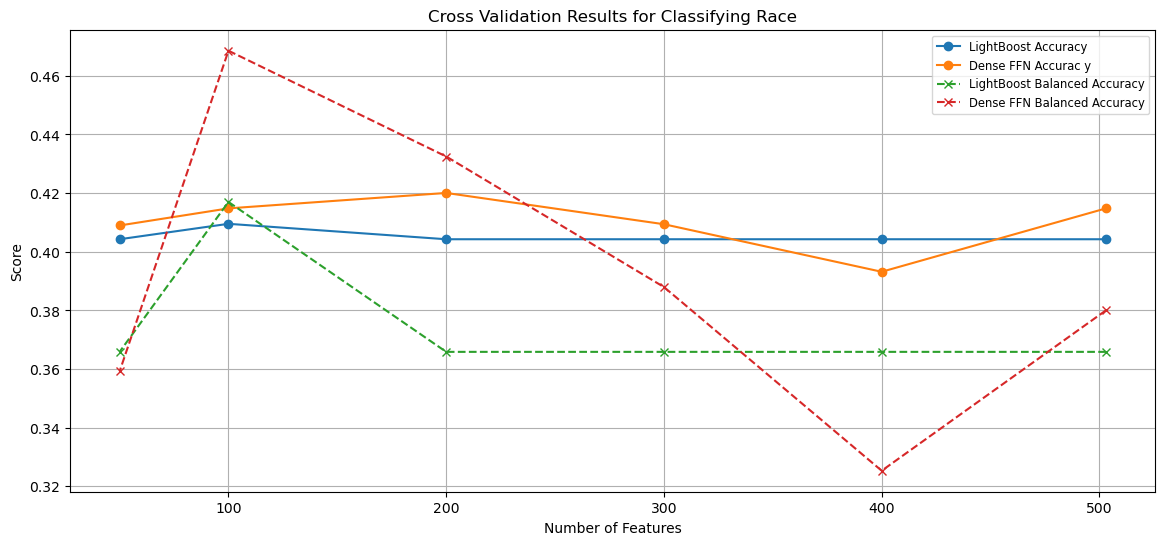

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 6))
plt.title("Cross Validation Results for Classifying Race")

# Plot accuracy metrics
plt.plot(numberOfFeatures, accTree, label="LightBoost Accuracy", marker='o')
plt.plot(numberOfFeatures, accDL, label="Dense FFN Accurac y", marker='o')

# Plot balanced accuracy metrics
plt.plot(numberOfFeatures, bAccTree, label="LightBoost Balanced Accuracy", linestyle='--', marker='x')
plt.plot(numberOfFeatures, bAccDL, label="Dense FFN Balanced Accuracy", linestyle='--', marker='x')

# Add labels, legend, and grid
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend(loc='best', fontsize='small')
plt.grid(True)

# Show plot
plt.show()